In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
RGB_NIR_data_path = '/content/drive/MyDrive/DEPI/Processed_Data/RGB_NIR'

In [4]:
# %pip install sklearn

In [5]:
# %conda install -c conda-forge tensorflow-gpu -y

In [6]:
os.listdir(RGB_NIR_data_path)

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'SeaLake',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River']

In [8]:
data_dir = RGB_NIR_data_path
classes = sorted(os.listdir(data_dir))
print("Found classes:", classes)
X = []
y = []
for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)

    for file in os.listdir(cls_folder):
        if file.endswith('.npy'):
            file_path = os.path.join(cls_folder, file)

            try:
                arr = np.load(file_path)

                if arr.size == 0:
                    print("Empty file skipped:", file_path)
                    continue

                if len(arr.shape) == 2:
                    arr = arr[..., np.newaxis]

                X.append(arr)
                y.append(idx)

            except Exception as e:
                print(f"Skipped corrupted file: {file_path} — {e}")
                continue

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} samples with shape {X.shape}")

Found classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Skipped corrupted file: /content/drive/MyDrive/DEPI/Processed_Data/RGB_NIR/AnnualCrop/AnnualCrop_2672.npy — No data left in file
Loaded 24791 samples with shape (24791, 64, 64, 4)


In [ ]:
num_classes = len(classes)
y_cat = to_categorical(y, num_classes)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [11]:
in_shape=(64, 64, 4)

In [12]:


model_RGB_NIR = Sequential([
    Conv2D(32, (3, 3), input_shape=in_shape, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


model_RGB_NIR.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_RGB_NIR.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,226,026 (8.49 MB)

 Trainable params: 2,225,578 (8.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
history = model_RGB_NIR.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 287s 912ms/step - accuracy: 0.5360 - loss: 1.6224 - val_accuracy: 0.3073 - val_loss: 7.8889
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 283s 912ms/step - accuracy: 0.7325 - loss: 0.8286 - val_accuracy: 0.6544 - val_loss: 1.3005
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 315s 890ms/step - accuracy: 0.8142 - loss: 0.5748 - val_accuracy: 0.7687 - val_loss: 0.6583
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 288s 929ms/step - accuracy: 0.8540 - loss: 0.4633 - val_accuracy: 0.9026 - val_loss: 0.3379
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 291s 937ms/step - accuracy: 0.8836 - loss: 0.3710 - val_accuracy: 0.5912 - val_loss: 1.3194
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 289s 932ms/step - accuracy: 0.8871 - loss: 0.3703 - val_accuracy: 0.8635 - val_loss: 0.3854
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 284s 917ms/step - accuracy: 0.8984 - loss: 0.3309 - val_accuracy: 0.7729 - val_loss: 0.7456
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 281s 908ms/step - accuracy: 0.9173 -

In [14]:
print("\nEvaluating the model:")
loss, accuracy = model_RGB_NIR.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating the model:
207/207 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9049 - loss: 0.3336
Validation Loss: 0.3379
Validation Accuracy: 0.9026


In [15]:
model_RGB_NIR = Sequential([
    Conv2D(32, (3, 3), input_shape=in_shape, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_RGB_NIR.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_RGB_NIR.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             

 Total params: 2,329,450 (8.89 MB)

 Trainable params: 2,326,954 (8.88 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [16]:
history = model_RGB_NIR.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.6097 - loss: 1.2709 - val_accuracy: 0.3077 - val_loss: 3.2723
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.8282 - loss: 0.5264 - val_accuracy: 0.8312 - val_loss: 0.5505
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.8775 - loss: 0.3961 - val_accuracy: 0.8667 - val_loss: 0.4132
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.8947 - loss: 0.3354 - val_accuracy: 0.7534 - val_loss: 0.8700
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.9198 - loss: 0.2680 - val_accuracy: 0.8885 - val_loss: 0.3429
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.9276 - loss: 0.2459 - val_accuracy: 0.9179 - val_loss: 0.2471
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.9328 - loss: 0.2166 - val_accuracy: 0.9044 - val_loss: 0.2903
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.9360 - loss: 0.1952 - val_accu

In [17]:

print("\nEvaluating the model:")
loss, accuracy = model_RGB_NIR.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")



Evaluating the model:
207/207 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9267 - loss: 0.2089
Validation Loss: 0.2090
Validation Accuracy: 0.9282


In [18]:
model_RGB_NIR.save('model_RGB_NIR_v0.h5')

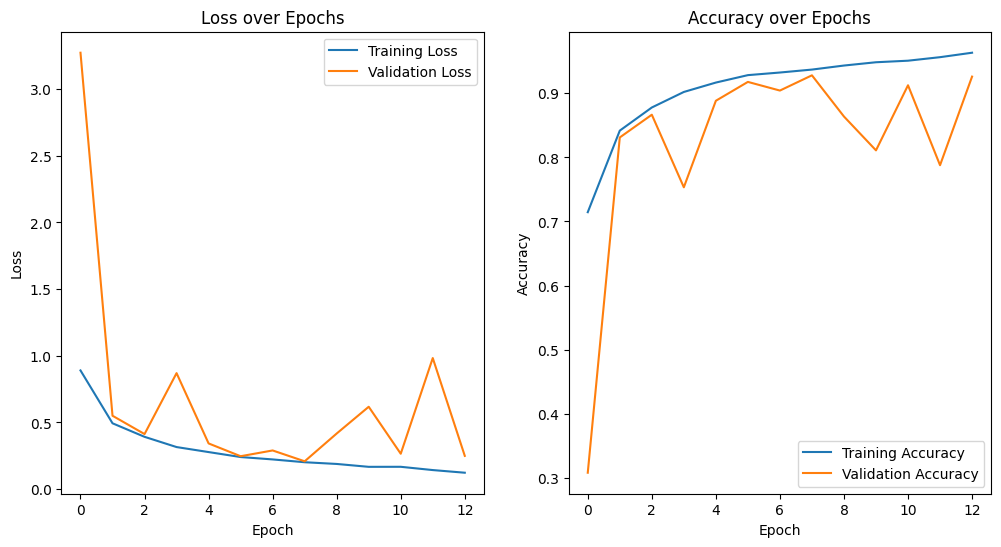

In [19]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()